# Project Week 1                                     <a id="chapter1"></a>
# Table of Contents

* [Project Week 1                                    ](#chapter1)
* [Student details](#chapter2)
* [Project Description                                         ](#chapter3)
* [Data                                    ](#chapter4)
* [Predictive Power of Tie Strength                                    ](#chapter5)
* [Predictive Power of the Number of Open Triades                                    ](#chapter6)
* [Ranking Friends of Friends                                    ](#chapter7)
* [Under construction                          ](#chapter8)


# Student details <a id="chapter2"></a>

Please enter the student numbers and names in the cell below.

Group 34:
- Cahid Arda Öz - 2872293
- Carlos de Bourbon de Parme – 2153874

# Project Description                                          <a id="chapter3"></a>



Faculty employees at research universities have two major activities: teaching and research. The research is often done in collaboration with colleagues, which results in a joint publication. In this project we will analyse collaborations within the EWI department of the University of Twente based on joint publications. Such investigations are important in order to enhance the research results and applications, and in order to allocate the limited funding to the right research groups and topics.

We represent each researcher as a vertex of a graph. We draw an undirected edge between two vertexes, if the corresponding two researchers have published a joint paper. The resulting graph is called a collaboration graph. We may label each edge as a weak or strong tie depending on the number of joint papers.
In this project we want to verify the following hypotheses:


In this project we want to verify the following hypotheses:

*	The collaborations adhere to the strong triadic closure property: if two researchers A and C both actively collaborate with researcher B, then the chance is high that A and C will collaborate in the future.
*	The large number of open triades, in which two researchers participate, implies that there is a high probability that the two researchers will collaborate in the future.

You task is to explore the given data and make a case whether or not the above hypotheses are true. Additionally, you will have to develop an algorithm that ranks friends of friends by decreasing likelihood of becoming a friend in the future.

In [1]:
# The following includes are needed to work with graphs and display solutions.
%matplotlib inline
# Extra package need to be installed on Google Colab.
!apt install libgraphviz-dev
!pip install pygraphviz
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from IPython.display import display
from collections import Counter
import utils
import graphs


Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgraphviz-dev is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


# Data                                     <a id="chapter4"></a>
The project is based on the UT collaboration graph. We made snapshots of the UT collaboration graph up to 1995 and up to 2015. The number of publications written by two researchers is noted as the weight of this edge. The following two statements load the collaborations up to these years. Note that they take some time to complete.

In [2]:
G1995 = utils.fromDot(open('bib-graph-1995.dot').read())
G2015 = utils.fromDot(open('bib-graph-2015.dot').read())

For example, in 1995, the researcher 283261 collaborated with researcher 176766, 520454, 617192, 729772, and 797848 and wrote with them 1, 6, 1, 5, and 2 papers respectively. This can be seen as follows:

In [3]:
G1995['283261']

AdjacencyView({'617192': {0: {'weight': '1.000000'}}, '729772': {0: {'weight': '5.000000'}}, '520454': {0: {'weight': '6.000000'}}, '797484': {0: {'weight': '2.000000'}}, '176766': {0: {'weight': '1.000000'}}})

In [4]:
G1995

# Predictive Power of Tie Strength                                     <a id="chapter5"></a>

Show that the probability of a new collaboration to be formed in an open triangle A -- B -- C is increasing with the strength of A -- B and B -- C, using a regression prediction. The tie strength is defined as $\frac{(x+y)}{2}$, where $x$ is the number of collaborations between A and B, and $y$ is the number of collaborations between B and C. The probability is defined as the chance that a new edge has formed between A and C between the G1995 and G2015 graph. You have to draw a  graph (with axis's lables and units) to illustrate your answer.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:175: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


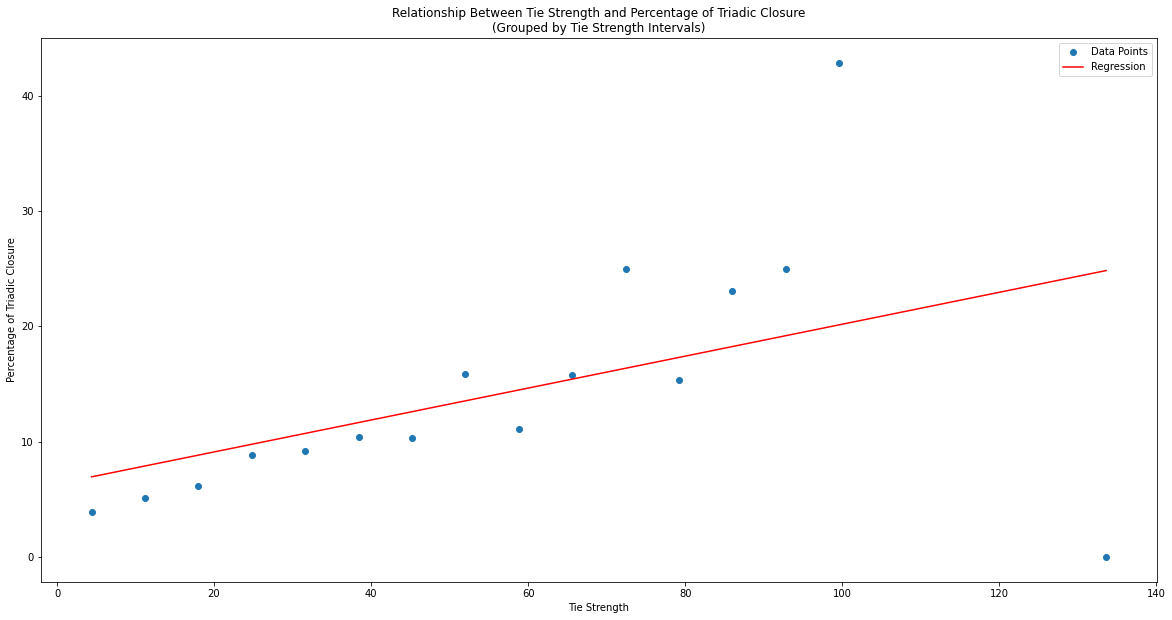

In [8]:
# BEGIN SOLUTION

# -----------------------
# 1. Data Structures
# -----------------------

class Pair:
    """Pair object represents two vertices a and c.

    Attributes:
        a (str): represents the first vertice of the pair
        c (str): represents the second vertice of the pair
        parent_nodes (list of str): Vertices a and c are initially non-adjacent
                and the parent_nodes list consists of vertices connected to
                both a and c. Each vertice in this list forms an open triad
                together with vertices a and c.
        tie_strength (float): tie strength of the pair
        
    """
    def __init__(self,a,c,parent_nodes):
        """Assigns the parameters as attributes 

        Args:
            a (str): represents the first vertice of the pair
            c (str): represents the second vertice of the pair
            parent_nodes (list of str): See the attribute explanation in 
                    class documentation.
        """
        self.a = a
        self.c = c
        self.parent_nodes = parent_nodes

        self.__get_tie_strength = lambda graph, neighbor: sum([float(graph[neighbor][node][0]['weight'])
                                                               for node in [self.a,self.c]])/2

    def assign_tie_strength(self, graph):
        """Calculate tie_strenth of the triangles of the pair object.

        Args:
            graph (MultiGraph): graph object is passed to the __get_tie_strength
                calculate tie strength based on edge weights.
        """
        self.tie_strength = sum([self.__get_tie_strength(graph, parent_node) for parent_node in self.parent_nodes])

    def assign_becomes_closed(self, graph):
        """Using the graph, check whether the pair becomes connected via an edge.

        Result is saved as becomes_closed attribute.

        
        Args:
            graph (MultiGraph): graph object is used to check whether the pair
                becomes connected.
        """
        self.becomes_closed = self.a in graph[self.c]

# -----------------------
# 2. Helper Methods
# -----------------------

# lambda method for finding common adjacent nodes for two nodes
get_common_neighbors = lambda graph, node1, node2: list(set(graph[node1]).intersection(graph[node2]))

def get_all_unconnected_pairs(graph):
    """Creates a list of Pair objects. These Pair objects are filtered such that
    only the ones which form an open triad are created and added to the list.

    Args:
        graph (MultiGraph): Graph object from which the open triads are searched

    Returns:
        List of Pair objects as explained in the method documentation above.
    """
    pairs = []
    nodes = list(graph.nodes())
    for i, node1 in enumerate(nodes):
        for node2 in nodes[i+1:]:

            # if nodes are connected, continue
            if node2 in graph[node1]:
                continue

            # if nodes don't have a common neighbor, continue
            common_neighbors = get_common_neighbors(graph, node1, node2)
            if len(common_neighbors) == 0:
                continue
            
            # Create Pair object and add it to the list
            pairs.append(Pair(node1, node2, common_neighbors))

    return pairs
    
def create_pairs(base_graph, updated_graph):
    """Driver method for the algorithm. Calls all the methods written to solve
    the problem.

    It creates the pairs using the base_graph, then calls methods to assign 
    tie_strength and becomes_closed attributes to the objects in the pairs
    list.

    Args:
        base_graph (MultiGraph): graph from which the non-adjacent pairs are
            detected. Tie strengths are also calculated based on this graph.
        updated_graph (MultiGraph): graph with which the becomes_closed
            attributes, which indicate whether the pairs became connected,
            are assigned.

    Returns:
        list of Pair objects
    """
    pairs = get_all_unconnected_pairs(base_graph)
    for pair in pairs:
        pair.assign_tie_strength(base_graph)
        pair.assign_becomes_closed(updated_graph)
    return pairs

def fit_line(x,y):
    """Method for regression

    Args:
        x (list): input of the regression model
        y (list): target of the regression model
    """
    p = np.polyfit(x, y, deg = 1)
    line = lambda x: p[0] * x + p[1]
    return line

# -----------------------
# 3. Processing the Pairs
# -----------------------

# Create pair objects
pairs = create_pairs(G1995, G2015)

# Calculate lowest and highest tie strengths found
tie_strengths = set()
for pair in pairs:
    tie_strengths.add(pair.tie_strength)
interval = [min(tie_strengths), max(tie_strengths)]

# Parameter for the number of tie strength groups
# Purpose of the grouping is explained below this code cell.
N_GROUPS = 20

# Calculate size of each group
step_size = (interval[1]-interval[0])/N_GROUPS
# Helper method for finding the group index from tie stregth
get_group_index = lambda value: int(value // step_size)

# List of lists representing the groups
groups = [[] for i in range(N_GROUPS)]

# Assigning pairs to the groups
for pair in pairs:
    index = get_group_index(pair.tie_strength)
    index = index if index != N_GROUPS else N_GROUPS - 1 # horrible
    groups[index].append(pair)

# Create boundaries and labels for the groups
f = lambda x: interval[0] + step_size * x
interval_boundaries = [[f(i), f(i+1)] for i in range(N_GROUPS)]
interval_name = lambda interval_boundary: "%.2f-%.2f"%tuple(interval_boundary)

# For each group, calculate percentages of pairs that became connected.
# group_data is a list of lists. Each sublist represents an interval.
# Format of each sublist: [interval_boundaries, n_pairs, probability]
group_data = []
for group, interval_boundary in zip(groups, interval_boundaries):
    connected = 0
    total = len(group)
    for pair in group:
        if pair.becomes_closed:
            connected += 1
    group_data.append([interval_boundary, total, 0 if total==0 else connected / total])
group_data = np.array(group_data)

# -----------------------
# 4. Regression
# -----------------------

regression_data = group_data[group_data[:, 1] != 0] # remove intervals with no pairs

interval_averages = [sum(i)/2 for i in regression_data[:,0]]
tie_strength_to_connection_probability = fit_line(interval_averages,
                                                  regression_data[:, 2].astype(np.float32))
# -----------------------
# 5. Plotting
# -----------------------

plt.figure(figsize=(20,10))
plt.title("Relationship Between Tie Strength and Percentage of Triadic Closure\n(Grouped by Tie Strength Intervals)")
plt.xlabel("Tie Strength")
plt.ylabel("Percentage of Triadic Closure")

labels = [interval_name(i) for i in interval_boundaries]

'''
plt.bar(labels,
        (group_data[:, 2]*100).astype(np.float32),
        tick_label = labels)

plt.plot([0, N_GROUPS-1],
        [tie_strength_to_connection_probability(i)*100 for i in [f(interval_averages) for f in (min, max)]],
        label="Regression",
        color='red')
'''

plt.plot(interval_averages,
        (regression_data[:, 2]*100).astype(np.float32),
         linestyle='None',
         marker='o',
         label = 'Data Points')

plt.plot([f(interval_averages) for f in (min, max)],
        [tie_strength_to_connection_probability(i)*100 for i in [f(interval_averages) for f in (min, max)]],
        label="Regression",
        color='red')

plt.legend()
plt.show()

# END SOLUTION


*Explanation: (Explanation for the proposed agorithm must be added here. The code above also needs comments in details for clarity and comprehension) 

In the plot above, you can see data points that represent different intervals of tie strength. Each non-adjacent pair which are part of an open triad are assigned a tie strength. Then these pairs are assigned to interval lists based on their tie strength. In the last step, percentage of pairs that formed a connection is calculated and we end up with the plot above. x values of the data points represent the average of each interval and the y value is the percentage of pairs that formed a connection.

Looking at the plot, we observe that the regression model fits well to the low values of tie strength but not to the higher values of tie strength. We believe that this inaccuracy is caused by the low number of pair samples where the tie strength is high. Because of the lack of samples, few samples we have have a greater-than-desired effect on the final percentage for the interval.

Code in the solution is split to 5 sections. Explanation of the code will follow the same structure:
1. Data Structures
2. Helper Methods
3. Processing the Pairs
4. Regression
5. Plotting

## 1. Data Structures

To make it easier to keep track of different variables, we found it beneficial to have a class called Pair. A pair object represents two vertices which are not adjacent in the initial graph and it keeps track of the following information about these two vertices:
- the ids of the vertice pair
- nodes which are adjacent to both vertices in the vertice pair
- tie strength of the pair
- whether the pair becomes connected in a future graph

## 2. Helper Methods

We wrote several helper methods to make it easier to use the code we had written. These methods are: 
1. get_common_neighbors
2. get_all_unconnected_pairs
3. create_pairs
4. fit_line

### 2.1 get_common_neighbors

This lambda function is used to find the vertices neighboring a pair of nodes

### 2.2 get_all_unconnected_pairs

This method is used to iterate over all the pairs in a graph and find every pair of vertices which are the two non-adjacent vertices in an open triad.

### 2.3 create_pairs

This method is used to create the list of pairs for future use.

### 2.4 fit_line

This method is for fitting a line through a set of data points.

## 3. Processing the Pairs

In this section, we use the code written in the other sections. Main solution to question 1 is here. We do the following things in this section:
* Pairs are created. Tie strengths are calculated and pairs are checked to see whether the they become adjacent in the graph of 2015.
* Pairs are split to N_GROUPS many groups based on tie strengths.
* Percentage of pairs which became adjacent in 2015 are calculated for each group

## 4. Processing the Pairs

After all the processing in the next step, a regression model is fitted to predict connection probability based on tie strength (`tie_strength_to_connection_probability`)

## 5. Plotting

Percentage data from the processing section and the regression model are fitted to showcase the relationship between tie strength and connection probability.

# Predictive Power of the Number of Open Triades                                     <a id="chapter6"></a>

Find a regression model to evaluate whether the number of open triades influences the probability that a new collaboration is formed between 1995 and 2015. For example, node A and C do not have an edge, but could be connected by B (one open triad), A and D (two open triades) or even A, D and E (three open triades) and so forth. You have to draw a graph (with axis's lables and units) to illustrate your answer.

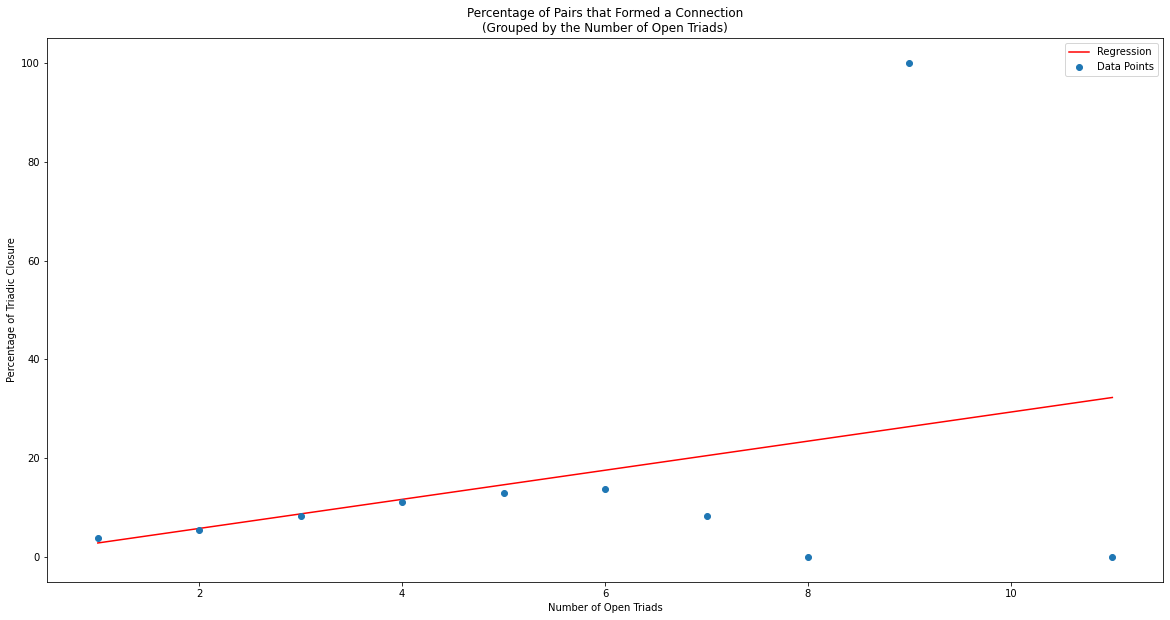

In [6]:
# BEGIN SOLUTION

# -----------------------
# Processing the Pairs
# -----------------------

# Dictionary mapping x (representing the number of triads) to the number of
# pairs with x many triads
n_open_triads_total     = {}
# Dictionary mapping x (representing the number of triads) to the number of
# pairs that become connected and are also with x many triads
n_open_triads_connected = {}

# Fill the two dictionaries created above 
for pair in pairs:
    n_open_triads = len(pair.parent_nodes)
    
    if n_open_triads not in n_open_triads_total:
        n_open_triads_total[n_open_triads] = 0
        n_open_triads_connected[n_open_triads] = 0

    n_open_triads_total[n_open_triads] += 1
    
    if pair.becomes_closed:
        n_open_triads_connected[n_open_triads] += 1   

# -----------------------
# Regression
# -----------------------

keys = list(n_open_triads_total.keys())
percentages = [n_open_triads_connected[key]/n_open_triads_total[key] for key in keys]

n_open_triads_to_connection_probability = fit_line(keys, percentages)

# -----------------------
# Plotting
# -----------------------

plt.figure(figsize=(20,10))
plt.title("Percentage of Pairs that Formed a Connection\n(Grouped by the Number of Open Triads)")
plt.xlabel("Number of Open Triads")
plt.ylabel("Percentage of Triadic Closure")

'''
plt.bar(keys,
        [percentage*100 for percentage in percentages],
        label = "Percentage",
        tick_label = keys
        )
'''

plt.plot([min(keys), max(keys)],
        [n_open_triads_to_connection_probability(i)*100 for i in [min(keys), max(keys)]],
        label="Regression",
        color='red')

plt.plot(keys,
        [percentage*100 for percentage in percentages],
         linestyle='None',
         marker='o',
         label = 'Data Points')

plt.legend()
plt.show()

# END SOLUTION

*Explanation: (Explanation for the proposed agorithm must be added here. The code above also needs comments in details for clarity and comprehension) 

In the plot above, you can see the relationship between the number of triads of a pair and the percentage of pairs that formed a connection for each pair group based on number of triads.

We see a similar pattern with question 1. We have many samples for low number of number of triads and not many for higher values. For values of x which are close to 0, we see a liniar trend that fits well to our model but accuracy detoriates as the number of triads increases and the number of samples are less.

In the solution of this question, we have three sections:
1. Processing the Pairs
2. Regression
3. Plotting

## 1. Processing the Pairs

In this section, we use the pairs list we generated in solution to the question 1 to build two dictionaries. These dictionaries map the number of open triads to the total number of pairs and number of pairs which became connected.

Using these two dictionaries, we can find out the percentage of the vertices which formed a pair for each group based on the number of open triads.

## 2. Regression

In this section, we fit a regression model mappinng number of triads to connection probability (`n_open_triads_to_connection_probability`).

## 3. Plotting

Percentage data from the processing section and the regression model are fitted to showcase the relationship between number of open triads and connection probability.

# Ranking Friends of Friends                                     <a id="chapter7"></a>

In this exercise you should apply your knowlege gained from the two previous exercises, but not limted to, to answer a common problem in todays social media platforms: given a person, an employee in our case, generate a ranked list of his friends of friends that are likely to become his friends. At the end of the following cell, we provide a code snippet that calculates the precision of your algorithm in predicting future ties in the top-10. Note that other knowledge you gained in the lectures also can be used to solve this problem.

In [7]:
# employees to test
nodes = ['943855', '587677', '905252', '839906', '554748', '220387', '456096', '136755', '652488', '617192', '154879', '860536', '127930', '266261', '925761', '334823', '879631', '922044', '485657', '347203']
# dictionary mapping an employee to a list of employees with whom he/she collaborated in 2015 and which belonged
# to his friends of friends in 1995. 
result = {'879631': ['587677', '265264', '925761', '860536', '725186', '721127', '142327', '23872', '943855'], '127930': ['26850', '935705', '136755', '659445', '805057', '293364', '681672', '565759', '868762', '596394'], '154879': ['691913', '817338', '659445', '169325', '542646', '644335', '293364', '165240', '485657', '905252', '408618'], '587677': ['879631', '725186', '785747', '70007', '561122', '136755', '721127', '142327', '72828', '334823', '839906', '433369', '943855'], '266261': ['265264', '208388', '70007', '495819', '725186', '839906', '136755', '721127', '142327', '408600'], '860536': ['811970', '879631', '456096', '839906', '396817', '136755', '653075', '72828', '596215', '346572', '922044'], '839906': ['587677', '308351', '860536', '378229', '240448', '379649', '334823', '201753', '565759', '943855', '174262', '922044', '266261'], '347203': ['265464', '578175', '136755', '596215', '220387', '906277', '897180', '652488'], '617192': ['793831', '254964', '522310', '932010', '528813', '922964', '485657', '58492', '694245', '166980', '905252'], '136755': ['811970', '127930', '587677', '266261', '815411', '422460', '860536', '347203', '943855', '691913', '174262', '922044'], '925761': ['879631', '725186', '456096', '70007', '561122', '136803', '596215', '334823', '905252', '943855'], '554748': ['23872', '916957', '659445', '169325', '644335', '293364', '220387', '433369', '943855', '174262', '922044', '652488'], '334823': ['587677', '725186', '785747', '839906', '721127', '142327', '72828', '925761', '943855', '867536'], '220387': ['450166', '571150', '565465', '901612', '554748', '18282', '883925', '347203', '9418', '943855', '265464', '652488'], '485657': ['811970', '154879', '617192', '702341', '41963', '661899', '293364', '668817', '218489'], '905252': ['23872', '742360', '561250', '523695', '222137', '617192', '564846', '925761', '661899', '571150', '154879', '691913', '392536'], '943855': ['265264', '60541', '220387', '14499', '783415', '679997', '811970', '785747', '961828', '587677', '925761', '905502', '561122', '136755', '41963', '554748', '879631', '642974', '725186', '676753', '839906', '213482', '396817', '721127', '576951', '334823', '978812'], '456096': ['206983', '925761', '706765', '860536', '565708', '296067', '902949', '549825', '201753', '961828', '240448', '922044'], '922044': ['456096', '308351', '860536', '839906', '136755', '554748', '433369', '999230', '240448'], '652488': ['602959', '60541', '846007', '143158', '347203', '422460', '14499', '554748', '220387', '265464', '9418']}

def fof(G,n):
    '''
    returns the friends of friends of Node n in Graph G
    '''
    res = set()
    for n1 in G[n]:
        res = res | set(G[n1])
    res = res - set(G[n])
    res = res - {n}
    return res

# BEGIN SOLUTION
# END SOLUTION

def score(n, f):
    '''
    calculates a score by which potential friends should be sorted
    '''

    s = 0
    # BEGIN SOLUTION

    common_neighbors = get_common_neighbors(G1995, n, f)    # find nodes which are connected to both n and f
    pair = Pair(n, f, common_neighbors)                     # create a pair object with n and f
    pair.assign_tie_strength(G1995)                         # calculate tie strength of n and f with the graph

    # use the regression models created in the solutions of question 1 and
    # question 2 to calculate estimated probabilities
    p = tie_strength_to_connection_probability(pair.tie_strength)
    q = n_open_triads_to_connection_probability(len(pair.parent_nodes))

    # evaluate s from the two probabilities
    s = 1-(1-p)*(1-q)
    
    # END SOLUTION
    return s

# Check 
topn = 10
for n in nodes:
    # get all friends of friends and their score
    fofG1995 = fof(G1995, n)
    l = [(f,score(n,f)) for f in fofG1995 ]
    # sort descending by score
    l.sort(key=lambda x: -x[1])
    # count number of correct results
    found = 0
    for x,z in l[:topn]:
        if x in result[n]:
            found += 1            
    print(n, found / float(topn))

943855 0.7
587677 0.6
905252 0.1
839906 0.4
554748 0.1
220387 0.2
456096 0.2
136755 0.3
652488 0.2
617192 0.3
154879 0.4
860536 0.3
127930 0.3
266261 0.4
925761 0.4
334823 0.4
879631 0.1
922044 0.4
485657 0.2
347203 0.5


*Explanation: (Explanation for the proposed agorithm must be added here. The code above also needs comments in details for clarity and comprehension)

To score pairs of vertices, we used the two regression we fitted for questions 1 and 2.

For each pair of vertices (n and f), we create a pair object and calculate tie strengths. Then we use the regression models to predict two probabilities of connection (p and q). These predictions are then used to calculate the final score.

The way we calculated final score from p and q is with the function `1-(1-p)*(1-q)`. The reason why we chose this method was that we first wanted to calculate the probability of no connection forming and then we subtracted this value from 1 to find the predicted probability of connection formation. We have also considered `p*q` as a score function but we observed that the fisrt method achieved higher scores.